In [7]:
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from prepare_hess_dataset import MyDataset
import networkx as nx
from torch_geometric.utils import to_networkx

In [8]:
def visualize_graph(G):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,  cmap="Set2")
    plt.show()

#### get the dataset and have a look

In [9]:
dataset = MyDataset('/home/woody/caph/mppi067h/gamma_ray_reconstruction_with_ml/gnn/hdf5_10cm_1000pe','test')

In [10]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: test(2940):
Number of graphs: 2940
Number of features: 3
Number of classes: 2

Data(x=[64, 3], edge_index=[2, 492], y=[1])
Number of nodes: 64
Number of edges: 492
Average node degree: 7.69
Has isolated nodes: True
Has self-loops: False
Is undirected: False


#### define the model

In [11]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [13]:
type(dataset)

prepare_hess_dataset.MyDataset

In [28]:
print(dataset)

test(2940)


#### make train and test split

In [14]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:int(0.6*len(dataset))]
test_dataset = dataset[int(0.6*len(dataset)):]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 1764
Number of test graphs: 1176


In [16]:
type(train_dataset)

prepare_hess_dataset.MyDataset

In [8]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print("number of node features:", data.num_node_features)
    if(step > 1):
        break

Step 1:
Number of graphs in the current batch: 27
DataBatch(x=[11126, 3], edge_index=[2, 1212625], y=[27], batch=[11126], ptr=[28])
number of node features: 3


1


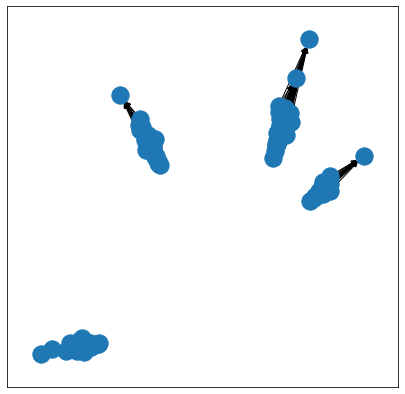

1


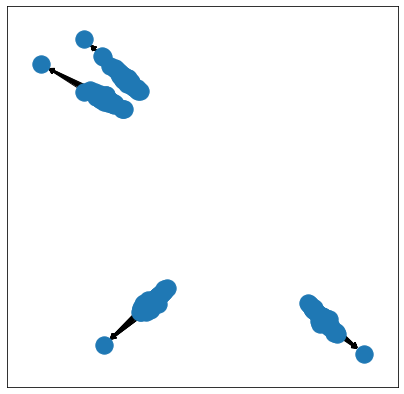

In [9]:
G = to_networkx(dataset[1])#, to_undirected=True)
print(dataset[1].y.numpy()[0])
visualize_graph(G)
G = to_networkx(dataset[5])#, to_undirected=True)
print(dataset[5].y.numpy()[0])
visualize_graph(G)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)
model = GCN(hidden_channels=64,num_node_features=3).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 30):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

device cpu
GCN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)
Epoch: 001, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 002, Train Acc: 1.0000, Test Acc: 1.0000


KeyboardInterrupt: 

In [2]:
from torch_geometric.datasets import Reddit
dataset = Reddit('data/Reddit')

In [5]:
data

1

#### let's only consider each tel separately

In [ ]:
# allEvents = list()
# xc = np.array(camera_coord['x'])
# yc = np.array(camera_coord['y'])
# for i in range(len(data_final)):
#     for j in range(4):
#         allEvents.append(np.stack((xc,yc,data_final[i][j]))) #x,y,pe      

In [ ]:
# numEnt = tree.GetEntries()
# print "Number of Entries" ,numEnt
# for entry in range(numEnt):
#     tree.GetEntry(1)
#     for i in range(obsPE.size()):
#         print()
#         ObsPE.append(obsPE[i])
#         ExpPE.append(expPE[i])
#         Likelihood.append(likelihood[i])
#     ObsPE = np.array(ObsPE)
#     ExpPE = np.array(ExpPE)
#     Likelihood = np.array(Likelihood)

In [ ]:
# import torch
# from torch_geometric.data import Data

# edge_index = torch.tensor([[1],
#                            [ 2]], dtype=torch.long)
# x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

# data = Data(x=x, edge_index=edge_index)

In [ ]:
# data_list = []
# for i, ev in enumerate(allEvents):
#     pe = ev[2]
#     x = ev[0][pe > 0]
#     y = ev[1][pe > 0]
#     pe = pe[pe > 0]
#     sum_pe = np.sum(pe)
#     if(sum_pe > 0):
#         x_com = np.sum(x*pe)/sum_pe
#         y_com = np.sum(y*pe)/sum_pe
#         edges = []
#         for i in range(len(pe)):
#             origX = x[i]
#             origY = y[i]
#             for j in range(len(pe)):
#                 tempX = x[j]
#                 tempY = y[j]
#                 dist = np.sqrt((tempX-origX)**2 + (tempY-origY)**2)
#                 if dist > 1.e-1 and dist < 10:
#                     edges.append([i,j])
#         edge_index = torch.tensor(np.array(edges), dtype=torch.long)
#         pe = np.array(pe)
#         x = np.array(x - x_com)
#         y = np.array(y - y_com)
#         nodes = torch.t(torch.tensor(np.array((x,y,pe)), dtype=torch.float))
#         if(i%2 == 0):
#             data = Data(x=nodes, edge_index=edge_index.t().contiguous(), y=0)
#         else:
#             data = Data(x=nodes, edge_index=edge_index.t().contiguous(), y=1)
#         data_list.append(data)
#     #print('num edges, points:',len(edges), len(pe))